In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
str(Path.cwd().parent)

'c:\\Users\\jaesc2\\GitHub\\skforecast'

In [2]:
import numpy as np 
import pandas as pd
from typing import Tuple, Optional, Union
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from sklearn.linear_model import LinearRegression
from skforecast.utils import check_y
from skforecast.utils import transform_series
from skforecast.utils import preprocess_y
import time
import numba as nb

# Create lags

In [3]:
def _create_lags(
    self, 
    y: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
    """       
    Transforms a 1d array into a 2d array (X) and a 1d array (y). Each row
    in X is associated with a value of y and it represents the lags that
    precede it.
    
    Notice that, the returned matrix X_data, contains the lag 1 in the first
    column, the lag 2 in the second column and so on.
    
    Parameters
    ----------        
    y : 1d numpy ndarray
        Training time series.

    Returns 
    -------
    X_data : 2d numpy ndarray, shape (samples - max(self.lags), len(self.lags))
        2d numpy array with the lagged values (predictors).
    
    y_data : 1d numpy ndarray, shape (samples - max(self.lags),)
        Values of the time series related to each row of `X_data`.
    
    """
        
    n_splits = len(y) - self.max_lag
    if n_splits <= 0:
        raise ValueError(
            f'The maximum lag ({self.max_lag}) must be less than the length '
            f'of the series ({len(y)}).'
        )
    
    X_data = np.full(shape=(n_splits, len(self.lags)), fill_value=np.nan, dtype=float)

    for i, lag in enumerate(self.lags):
        X_data[:, i] = y[self.max_lag - lag: -lag]

    y_data = y[self.max_lag:]
        
    return X_data, y_data



def _create_lags_new(
    self, 
    y: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
    """       
    Transforms a 1d array into a 2d array (X) and a 1d array (y). Each row
    in X is associated with a value of y and it represents the lags that
    precede it.
    
    Notice that, the returned matrix X_data, contains the lag 1 in the first
    column, the lag 2 in the second column and so on.
    
    Parameters
    ----------        
    y : 1d numpy ndarray
        Training time series.

    Returns 
    -------
    X_data : 2d numpy ndarray, shape (samples - max(self.lags), len(self.lags))
        2d numpy array with the lagged values (predictors).
    
    y_data : 1d numpy ndarray, shape (samples - max(self.lags),)
        Values of the time series related to each row of `X_data`.
    
    """
    
    n_splits = len(y) - self.max_lag
    if n_splits <= 0:
        raise ValueError(
            f'The maximum lag ({self.max_lag}) must be less than the length '
            f'of the series ({len(y)}).'
        )

    index_array = np.arange(self.max_lag)[:, None] - np.arange(self.max_lag - len(y), dtype=int)

    X_data = y[index_array[:-1 * len(self.lags), :len(self.lags)]]
    y_data = y[self.max_lag:]

    return X_data, y_data


In [26]:
lags = 500
self = ForecasterAutoreg(regressor=LinearRegression(), lags=lags)
y = np.random.normal(size=100000)

start = time.time()
X = _create_lags(self, y=y)
print(f"Time taken _create_lags: {time.time() - start}")



start = time.time()
X = _create_lags_new(self, y=y)
print(f"Time taken _create_lags_new: {time.time() - start}")

Time taken _create_lags: 0.6470608711242676
Time taken _create_lags_new: 0.0012028217315673828


In [8]:
# Profiling `_create_lags` for different length of series and number of lags
# ======================================================================================
series_length = np.linspace(1000, 1000000, num=5, dtype=int)
n_lags = [5, 10, 50, 100, 200]
results = {}

for lags in n_lags:
    execution_time = []
    self = ForecasterAutoreg(regressor=LinearRegression(), lags=lags)

    for n in series_length:
        y = np.random.normal(size=n)
        tic = time.perf_counter()
        _ = _create_lags(self, y=y)
        toc = time.perf_counter()
        execution_time.append(toc-tic)

    results[lags] = execution_time

results = pd.DataFrame(
              data =  results,
              index = series_length
          )

results

,5,10,50,100,200
1000,0.000242,0.001026,0.002356,0.008464,0.015897
250750,0.003495,0.009611,0.193564,0.230684,0.271816
500500,0.009737,0.031638,0.393094,0.566737,1.101087
750250,0.014285,0.052606,0.469482,0.834637,1.709996
1000000,0.023364,0.070215,0.580613,1.130334,2.026127


In [7]:
# Profiling `_create_lags_new` for different length of series and number of lags
# ======================================================================================
series_length = np.linspace(1000, 1000000, num=5, dtype=int)
n_lags = [5, 10, 50, 100, 200]
results = {}

for lags in n_lags:
    execution_time = []
    self = ForecasterAutoreg(regressor=LinearRegression(), lags=lags)

    for n in series_length:
        y = np.random.normal(size=n)
        tic = time.perf_counter()
        _ = _create_lags_new(self, y=y)
        toc = time.perf_counter()
        execution_time.append(toc-tic)

    results[lags] = execution_time

results = pd.DataFrame(
              data =  results,
              index = series_length
          )

results

,5,10,50,100,200
1000,0.000053,0.000187,0.000189,0.000180,0.000190
250750,0.000043,0.000054,0.000025,0.000028,0.000020
500500,0.000178,0.000095,0.000105,0.000073,0.000061
750250,0.000150,0.000146,0.000135,0.000137,0.000106
1000000,0.000190,0.000205,0.000179,0.000176,0.000158


# Exog to direc

In [80]:
# Current implementation with numpy
# ==============================================================================
def exog_to_direct_numpy(
    exog: np.ndarray,
    steps: int
)-> np.ndarray:
    """
    Transforms `exog` to `np.ndarray` with the shape needed for direct
    forecasting.
    
    Parameters
    ----------        
    exog : numpy ndarray, shape(samples,)
        Time series values.

    steps : int.
        Number of steps that will be predicted using this exog.

    Returns 
    -------
    exog_transformed : numpy ndarray
        Exog transformed.

    """

    exog_transformed = []

    if exog.ndim < 2:
        exog = exog.reshape(-1, 1)

    for column in range(exog.shape[1]):

        exog_column_transformed = []
        
        for i in range(exog.shape[0] - (steps -1)):
            exog_column_transformed.append(exog[i:i + steps, column])
        
        if len(exog_column_transformed) > 1:
            exog_column_transformed = np.vstack(exog_column_transformed)
        
        exog_transformed.append(exog_column_transformed)

    if len(exog_transformed) > 1:
        exog_transformed = np.hstack(exog_transformed)
    else:
        exog_transformed = exog_column_transformed

    return exog_transformed


# Implementation with numpy suggested by chatgtp
# ==============================================================================
def exog_to_direct_numpy_new(
        exog: np.ndarray,
        steps: int
) -> np.ndarray:
    """
    Transforms `exog` to `numpy.ndarray` with the shape needed for direct forecasting.

    Parameters
    ----------
    exog : numpy ndarray, shape(samples, columns)
        Time series values.

    steps : int.
        Number of steps that will be predicted using this exog.

    Returns
    -------
    exog_transformed : numpy ndarray
        Exog transformed.

    """
    exog_transformed = []
    
    if exog.ndim == 1:
        exog = np.expand_dims(exog, axis=1)

    for i in range(exog.shape[1]):
        exog_column = exog[:, i]
        exog_column_transformed = np.vstack(
            [np.roll(exog_column, j) for j in range(steps)]
        ).T[steps - 1:]
        exog_column_transformed = exog_column_transformed[:, ::-1]
        exog_transformed.append(exog_column_transformed)

    if len(exog_transformed) > 1:
        exog_transformed = np.concatenate(exog_transformed, axis=1)
    else:
        exog_transformed = exog_column_transformed

    return exog_transformed




# Implementation with pandas suggested by chatgtp
# ==============================================================================
def exog_to_direct_pandas(
    exog: Union[np.ndarray, pd.DataFrame],
    steps: int
)-> np.ndarray:
    """
    Transforms `exog` to `pd.DataFrame` with the shape needed for direct
    forecasting.

    Parameters
    ----------
    exog : pandas DataFrame, shape(samples, columns)
        Time series values.

    steps : int.
        Number of steps that will be predicted using this exog.

    Returns
    -------
    exog_transformed : pandas DataFrame
        Exog transformed.

    """

    exog_transformed = []

    if exog.ndim == 1:
        exog = exog.to_frame()

    for column in exog.columns:

        exog_column_transformed = [exog[column].shift(i) for i in range(steps)][::-1]
        exog_column_transformed = pd.concat(exog_column_transformed, axis=1).dropna()
        exog_column_transformed.columns = [f"{column}_step_{i+1}" for i in range(steps)]

        exog_transformed.append(exog_column_transformed)

    if len(exog_transformed) > 1:
        exog_transformed = pd.concat(exog_transformed, axis=1)
    else:
        exog_transformed = exog_column_transformed

    return exog_transformed

In [81]:
lags = 5
steps = 3
exog = np.arange(10000)
print(f"Initial exog shape: {exog.shape}")

print("")
print("Current implementation with numpy")
start = time.time()
X_1 = exog_to_direct_numpy(steps=steps, exog=exog)
print(f"Time taken: {time.time() - start}")
print(X_1.shape)
print("")

print("Implementation with numpy suggested by chatgtp")
start = time.time()
X_2 = exog_to_direct_numpy_new(steps=steps, exog=exog)
print(f"Time taken: {time.time() - start}")
print(X_2.shape)
print("")


print("Implementation with pandas suggested by chatgtp")
exog = pd.Series(exog)
start = time.time()
X_3 = exog_to_direct_pandas(steps=steps, exog=exog)
print(f"Time taken: {time.time() - start}")
print(X_3.shape)
print("")


np.testing.assert_array_equal(X_1, X_2)
np.testing.assert_array_equal(X_1, X_3.to_numpy())

Initial exog shape: (10000,)

Current implementation with numpy
Time taken: 0.009999990463256836
(9998, 3)

Implementation with numpy suggested by chatgtp
Time taken: 0.0
(9998, 3)

Implementation with pandas suggested by chatgtp
Time taken: 0.0020017623901367188
(9998, 3)



In [143]:
lags = 5
steps = 3
self = ForecasterAutoregDirect(regressor=LinearRegression(), lags=lags, steps=steps)

exog = np.arange(10000).reshape(-1, 2)
print(f"Initial exog shape: {exog.shape}")
print("")

print("Current implementation with numpy")
start = time.time()
X_1 = exog_to_direct_numpy(steps=steps, exog=exog)
print(f"Time taken: {time.time() - start}")
print(X_1.shape)
print("")

print("Implementation with numpy suggested by chatgtp")
start = time.time()
X_2 = exog_to_direct_numpy_new(steps=steps, exog=exog)
print(f"Time taken: {time.time() - start}")
print(X_2.shape)
print("")


print("Implementation with pandas suggested by chatgtp")
exog = pd.DataFrame(exog)
start = time.time()
X_3 = exog_to_direct_pandas(steps=steps, exog=exog)
print(f"Time taken: {time.time() - start}")
print(X_3.shape)
print("")


print("Implementation with pandas suggested by chatgtp 2")
exog = pd.DataFrame(exog)
start = time.time()
X_4 = exog_to_direct_pandas_2(steps=steps, exog=exog)
print(f"Time taken: {time.time() - start}")
print(X_4.shape)
print("")


np.testing.assert_array_equal(X_1, X_2)
np.testing.assert_array_equal(X_1, X_3.to_numpy())
np.testing.assert_array_equal(X_1, X_4.to_numpy())

Initial exog shape: (5000, 2)

Current implementation with numpy
Time taken: 0.009001016616821289
(4998, 6)

Implementation with numpy suggested by chatgtp
Time taken: 0.0
(4998, 6)

Implementation with pandas suggested by chatgtp
Time taken: 0.004004001617431641
(4998, 6)

Implementation with pandas suggested by chatgtp 2
Time taken: 0.0009872913360595703
(4998, 6)



In [142]:
def exog_to_direct_pandas_2(
    exog: Union[np.ndarray, pd.DataFrame],
    steps: int
)-> np.ndarray:

    exog_transformed = []

    if exog.ndim == 1:
        exog = exog.to_frame()

    for column in exog.columns:

        exog_column_transformed = [exog[column].shift(i, fill_value=0) for i in range(steps)][::-1]
        exog_column_transformed = pd.concat(exog_column_transformed, axis=1)
        exog_column_transformed.columns = [f"{column}_step_{i+1}" for i in range(steps)]

        exog_transformed.append(exog_column_transformed)

    if len(exog_transformed) > 1:
        exog_transformed = pd.concat(exog_transformed, axis=1)
    else:
        exog_transformed = exog_column_transformed

    exog_transformed = exog_transformed.iloc[steps-1:,]

    return exog_transformed

In [213]:
exog = pd.DataFrame({'exog_1': pd.Categorical(range(1000)),
                     'exog_2': pd.Series(np.arange(1000), dtype=int),
                     'exog_3': pd.Series(np.arange(1000), dtype=float)})
exog.head(3)


,exog_1,exog_2,exog_3
0,0,0,0.0
1,1,1,1.0
2,2,2,2.0


In [153]:
exog.dtypes

exog_1    category
exog_2       int32
exog_3     float64
dtype: object

In [154]:
exog_tr = exog_to_direct_pandas_2(exog, 2)
print(exog_tr.dtypes)
exog_tr.head(3)

exog_1_step_1    category
exog_1_step_2    category
exog_2_step_1       int32
exog_2_step_2       int32
exog_3_step_1     float64
exog_3_step_2     float64
dtype: object


,exog_1_step_1,exog_1_step_2,exog_2_step_1,exog_2_step_2,exog_3_step_1,exog_3_step_2
1,0,1,0,1,0.0,1.0
2,1,2,1,2,1.0,2.0
3,2,3,2,3,2.0,3.0


In [200]:
exog_tr = exog_to_direct_pandas(exog, 2)
print(exog_tr.dtypes)
exog_tr.head(3)

exog_1_step_1    category
exog_1_step_2    category
exog_2_step_1    category
exog_2_step_2    category
dtype: object


,exog_1_step_1,exog_1_step_2,exog_2_step_1,exog_2_step_2
1,0,1,100,101
2,1,2,101,102
3,2,3,102,103


In [254]:
lags = 5
steps = 3
self = ForecasterAutoregDirect(regressor=LinearRegression(), lags=lags, steps=steps)

exog = pd.DataFrame({'exog_1': pd.Categorical(range(1000)),
                     'exog_2': pd.Series(np.arange(1000), dtype=int),
                     'exog_3': pd.Series(np.arange(1000), dtype=float)})
exog = exog.to_numpy()

# exog = np.arange(10000).reshape(-1, 2)
print(f"Initial exog shape: {exog.shape}")
print("")

print("Current implementation with numpy")
start = time.time()
X_1 = exog_to_direct_numpy(steps=steps, exog=exog)
print(f"Time taken: {time.time() - start}")
print(X_1.shape)
print("")

print("Implementation with numpy suggested by chatgtp")
start = time.time()
X_2 = exog_to_direct_numpy_new(steps=steps, exog=exog)
print(f"Time taken: {time.time() - start}")
print(X_2.shape)
print("")


print("Implementation with pandas suggested by chatgtp")
exog = pd.DataFrame(exog)
start = time.time()
X_3 = exog_to_direct_pandas(steps=steps, exog=exog)
print(f"Time taken: {time.time() - start}")
print(X_3.shape)
print("")


print("Implementation with pandas suggested by chatgtp 2")
exog = pd.DataFrame(exog)
start = time.time()
X_4 = exog_to_direct_pandas_2(steps=steps, exog=exog)
print(f"Time taken: {time.time() - start}")
print(X_4.shape)
print("")


print("Implementation with pandas suggested by chatgtp 3")
exog = pd.DataFrame(exog)
start = time.time()
X_5 = exog_to_direct_pandas_3(steps=steps, exog=exog)
print(f"Time taken: {time.time() - start}")
print(X_5.shape)
print("")


np.testing.assert_array_equal(X_1, X_2)
np.testing.assert_array_equal(X_1, X_3.to_numpy())
np.testing.assert_array_equal(X_1, X_4.to_numpy())
np.testing.assert_array_equal(X_1, X_5.to_numpy())

Initial exog shape: (1000, 3)

Current implementation with numpy
Time taken: 0.003000497817993164
(998, 9)

Implementation with numpy suggested by chatgtp
Time taken: 0.0
(998, 9)

Implementation with pandas suggested by chatgtp
Time taken: 0.0049936771392822266
(998, 9)

Implementation with pandas suggested by chatgtp 2
Time taken: 0.0009996891021728516
(998, 9)

Implementation with pandas suggested by chatgtp 3
Time taken: 0.0019998550415039062
(998, 9)



In [216]:
column = 'exog_2'
steps = 2

exog_column_transformed = [exog[column].shift(i, fill_value=0) for i in range(steps)][::-1]
exog_column_transformed = pd.concat(exog_column_transformed, axis=1)
exog_column_transformed.columns = [f"{column}_step_{i+1}" for i in range(steps)]
exog_column_transformed.dtypes

exog_2_step_1    int32
exog_2_step_2    int32
dtype: object

In [165]:
exog

,exog_1,exog_2,exog_3
0,0,0,0.0
1,1,1,1.0
2,2,2,2.0
3,3,3,3.0
4,4,4,4.0
...,...,...,...
995,995,995,995.0
996,996,996,996.0
997,997,997,997.0
998,998,998,998.0


In [175]:
exog = pd.DataFrame(pd.Series(np.arange(10), dtype=float), columns=['exog'])
exog.head(2)

,exog
0,0.0
1,1.0


In [180]:
exog_to_direct_pandas_2(steps=2, exog=exog).shape

(9, 2)

In [185]:
pd.DataFrame(
            data = np.array([[4., 3., 2., 1., 0.],
                             [5., 4., 3., 2., 1.],
                             [6., 5., 4., 3., 2.],
                             [7., 6., 5., 4., 3.],
                             [8., 7., 6., 5., 4.]]),
            index   = np.array([5, 6, 7, 8, 9]),
            columns = ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']
        ).assign(exog=pd.Categorical(range(5, 10), categories=range(10))).dtypes

,lag_1,lag_2,lag_3,lag_4,lag_5,exog
5,4.0,3.0,2.0,1.0,0.0,NaN
6,5.0,4.0,3.0,2.0,1.0,NaN
7,6.0,5.0,4.0,3.0,2.0,NaN
8,7.0,6.0,5.0,4.0,3.0,NaN
9,8.0,7.0,6.0,5.0,4.0,NaN


In [196]:
pd.DataFrame({'exog_step_1': pd.Series(range(10), dtype='category'),
                             'exog_step_2': pd.Series(range(1, 11), dtype='category')})

,exog_step_1,exog_step_2
0,0,1
1,1,2
2,2,3
3,3,4
4,4,5
5,5,6
6,6,7
7,7,8
8,8,9
9,9,10


In [198]:
exog = pd.DataFrame({'exog_1': pd.Categorical(range(10)),
                         'exog_2': pd.Categorical(range(100, 110))})
exog

,exog_1,exog_2
0,0,100
1,1,101
2,2,102
3,3,103
4,4,104
5,5,105
6,6,106
7,7,107
8,8,108
9,9,109


In [199]:
pd.DataFrame({'exog_1_step_1': pd.Categorical(range(9), categories=range(10)),
              'exog_1_step_2': pd.Categorical(range(1, 10), categories=range(10)),
              'exog_2_step_1': pd.Categorical(range(100, 109), categories=range(100, 110)),
              'exog_2_step_2': pd.Categorical(range(101, 110), categories=range(100, 110))})

,exog_1_step_1,exog_1_step_2,exog_2_step_1,exog_2_step_2
0,0,1,100,101
1,1,2,101,102
2,2,3,102,103
3,3,4,103,104
4,4,5,104,105
5,5,6,105,106
6,6,7,106,107
7,7,8,107,108
8,8,9,108,109


In [24]:
def exog_to_direct_pandas_3(
    exog: Union[np.ndarray, pd.DataFrame],
    steps: int
)-> np.ndarray:

    if not isinstance(exog, (pd.Series, pd.DataFrame)):
        raise TypeError("`exog` must be a pandas Series or DataFrame.")

    if isinstance(exog, pd.Series):
        exog = exog.to_frame()

    len_columns = len(exog)
    exog_idx = exog.index
    exog_transformed = []
    for column in exog.columns:

        exog_column_transformed = [
            (exog[column].iloc[i : len_columns - (steps - 1 - i)]).reset_index(drop=True)
            for i in range(steps)
        ]
        exog_column_transformed = pd.concat(exog_column_transformed, axis=1)
        exog_column_transformed.columns = [f"{column}_step_{i+1}" for i in range(steps)]

        exog_transformed.append(exog_column_transformed)

    if len(exog_transformed) > 1:
        exog_transformed = pd.concat(exog_transformed, axis=1)
    else:
        exog_transformed = exog_column_transformed

    exog_transformed.index= exog_idx[:len(exog_transformed)]

    return exog_transformed

In [25]:
exog = pd.DataFrame({'exog_1': pd.Categorical(range(10)),
                     'exog_2': pd.Series(np.arange(10), dtype=int),
                     'exog_3': pd.Series(np.arange(10), dtype=float)})
exog_to_direct_pandas_3(steps=2, exog=exog).iloc[-5:, :]

,exog_1_step_1,exog_1_step_2,exog_2_step_1,exog_2_step_2,exog_3_step_1,exog_3_step_2
4,4,5,4,5,4.0,5.0
5,5,6,5,6,5.0,6.0
6,6,7,6,7,6.0,7.0
7,7,8,7,8,7.0,8.0
8,8,9,8,9,8.0,9.0


In [7]:
exog_to_direct_pandas_3(steps=2, exog=exog)

,exog_1_step_1,exog_1_step_2,exog_2_step_1,exog_2_step_2,exog_3_step_1,exog_3_step_2
0,0,1,0,1,0.0,1.0
1,1,2,1,2,1.0,2.0
2,2,3,2,3,2.0,3.0
3,3,4,3,4,3.0,4.0
4,4,5,4,5,4.0,5.0
5,5,6,5,6,5.0,6.0
6,6,7,6,7,6.0,7.0
7,7,8,7,8,7.0,8.0
8,8,9,8,9,8.0,9.0


In [4]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

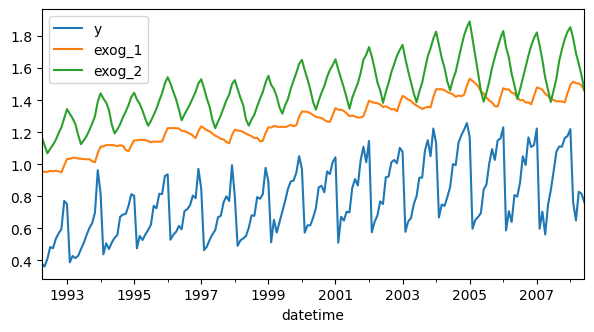

In [15]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv')
data = pd.read_csv(url, sep=',', header=0, names=['datetime', 'y', 'exog_1', 'exog_2'])

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y/%m/%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data.sort_index()

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(7, 3.5))
data.plot(ax=ax);

In [19]:
data.iloc[:10,0]

datetime
1992-04-01    0.379808
1992-05-01    0.361801
1992-06-01    0.410534
1992-07-01    0.483389
1992-08-01    0.475463
1992-09-01    0.534761
1992-10-01    0.568606
1992-11-01    0.595223
1992-12-01    0.771258
1993-01-01    0.751503
Freq: MS, Name: y, dtype: float64

In [28]:
data.iloc[:10, 1:]

,exog_1,exog_2
datetime,,
1992-04-01,0.958792,1.166029
1992-05-01,0.951993,1.117859
1992-06-01,0.952955,1.067942
1992-07-01,0.958078,1.097376
1992-08-01,0.956370,1.122199
1992-09-01,0.959610,1.153190
1992-10-01,0.956205,1.194551
1992-11-01,0.949715,1.231489
1992-12-01,0.993219,1.289062


In [29]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoregDirect(
                 regressor = Ridge(),
                 steps     = 2,
                 lags      = 3
             )

forecaster.create_train_X_y(y=data.iloc[:10,0])[0]

# forecaster.create_train_X_y(y=data.iloc[:10,0], 
#                             exog=data.iloc[:10, 1:])[0]

,lag_1,lag_2,lag_3
datetime,,,
1992-08-01,0.410534,0.361801,0.379808
1992-09-01,0.483389,0.410534,0.361801
1992-10-01,0.475463,0.483389,0.410534
1992-11-01,0.534761,0.475463,0.483389
1992-12-01,0.568606,0.534761,0.475463
1993-01-01,0.595223,0.568606,0.534761


In [32]:
forecaster.create_train_X_y(y=data.iloc[:10,0], 
                            exog=data.iloc[:10, 1:])[0]

,lag_1,lag_2,lag_3,exog_1_step_1,exog_1_step_2,exog_2_step_1,exog_2_step_2
datetime,,,,,,,
1992-08-01,0.410534,0.361801,0.379808,0.958078,0.956370,1.097376,1.122199
1992-09-01,0.483389,0.410534,0.361801,0.956370,0.959610,1.122199,1.153190
1992-10-01,0.475463,0.483389,0.410534,0.959610,0.956205,1.153190,1.194551
1992-11-01,0.534761,0.475463,0.483389,0.956205,0.949715,1.194551,1.231489
1992-12-01,0.568606,0.534761,0.475463,0.949715,0.993219,1.231489,1.289062
1993-01-01,0.595223,0.568606,0.534761,0.993219,1.033235,1.289062,1.344270


In [34]:
forecaster.create_train_X_y(y=data.iloc[:10,0], 
                            exog=data.iloc[:10, 1:])[1]

,y_step_1,y_step_2
datetime,,
1992-08-01,0.483389,0.475463
1992-09-01,0.475463,0.534761
1992-10-01,0.534761,0.568606
1992-11-01,0.568606,0.595223
1992-12-01,0.595223,0.771258
1993-01-01,0.771258,0.751503


In [33]:
data.iloc[:10,:]

,y,exog_1,exog_2
datetime,,,
1992-04-01,0.379808,0.958792,1.166029
1992-05-01,0.361801,0.951993,1.117859
1992-06-01,0.410534,0.952955,1.067942
1992-07-01,0.483389,0.958078,1.097376
1992-08-01,0.475463,0.956370,1.122199
1992-09-01,0.534761,0.959610,1.153190
1992-10-01,0.568606,0.956205,1.194551
1992-11-01,0.595223,0.949715,1.231489
1992-12-01,0.771258,0.993219,1.289062


In [24]:
from skforecast.exceptions import MissingValuesExogWarning
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from skforecast.ForecasterAutoregMultiVariate import ForecasterAutoregMultiVariate

series = pd.DataFrame({'l1': np.arange(10, dtype=float), 
                        'l2': np.arange(10, dtype=float)},
                        index = pd.date_range("1990-01-01", periods=10, freq='D'))
exog = pd.DataFrame({
            'col_1': [7.5, 24.4, 60.3, 57.3, 50.7, 41.4, 24.4, 87.2, 47.4, 23.8],
            'col_2': ['a', 'b', 'a', 'b', 'a', 'b', 'a', 'b', 'a', 'b']},
            index = pd.date_range("1990-01-01", periods=10, freq='D'))

transformer_exog = ColumnTransformer(
                        [('scale', StandardScaler(), ['col_1']),
                        ('onehot', OneHotEncoder(), ['col_2'])],
                        remainder = 'passthrough',
                        verbose_feature_names_out = False
                    )

forecaster = ForecasterAutoregMultiVariate(
                    regressor          = LinearRegression(),
                    lags               = 5,
                    level              = 'l1',
                    steps              = 2,
                    transformer_series = StandardScaler(),
                    transformer_exog   = transformer_exog
                )
results = forecaster.create_train_X_y(series=series, exog=exog)

In [27]:
results[0].columns

Index(['l1_lag_1', 'l1_lag_2', 'l1_lag_3', 'l1_lag_4', 'l1_lag_5', 'l2_lag_1',
       'l2_lag_2', 'l2_lag_3', 'l2_lag_4', 'l2_lag_5', 'col_1_step_1',
       'col_1_step_2', 'col_2_a_step_1', 'col_2_a_step_2', 'col_2_b_step_1',
       'col_2_b_step_2'],
      dtype='object')

In [28]:
results[1].to_numpy()

array([[0.17407766, 0.52223297],
       [0.52223297, 0.87038828],
       [0.87038828, 1.21854359],
       [1.21854359, 1.5666989 ]])

In [30]:
from skforecast.utils import exog_to_direct

exog = pd.DataFrame({'exog_1': pd.Categorical(range(10)),
                         'exog_2': pd.Categorical(range(100, 110))})
results = exog_to_direct(exog=exog, steps=2)
results

,exog_1_step_1,exog_1_step_2,exog_2_step_1,exog_2_step_2
1,0,1,100,101
2,1,2,101,102
3,2,3,102,103
4,3,4,103,104
5,4,5,104,105
6,5,6,105,106
7,6,7,106,107
8,7,8,107,108
9,8,9,108,109
